数据来源：在线零售数据集https://archive.ics.uci.edu/dataset/352/online+retail

In [1]:
import pandas as pd 

# 数据文件读取
data = pd.read_excel("Online Retail.xlsx")
print('The shape is: ',data.shape)
print(data.describe())
data.head()

The shape is:  (541909, 8)
            Quantity                    InvoiceDate      UnitPrice  \
count  541909.000000                         541909  541909.000000   
mean        9.552250  2011-07-04 13:34:57.156386048       4.611114   
min    -80995.000000            2010-12-01 08:26:00  -11062.060000   
25%         1.000000            2011-03-28 11:34:00       1.250000   
50%         3.000000            2011-07-19 17:17:00       2.080000   
75%        10.000000            2011-10-19 11:27:00       4.130000   
max     80995.000000            2011-12-09 12:50:00   38970.000000   
std       218.081158                            NaN      96.759853   

          CustomerID  
count  406829.000000  
mean    15287.690570  
min     12346.000000  
25%     13953.000000  
50%     15152.000000  
75%     16791.000000  
max     18287.000000  
std      1713.600303  


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [2]:
#查看唯一值
for col in data.columns:
    print(col, ' : ')
    print(data[col].unique(),'\n')

InvoiceNo  : 
[536365 536366 536367 ... 581585 581586 581587] 

StockCode  : 
['85123A' 71053 '84406B' ... '90214U' '47591b' 23843] 

Description  : 
['WHITE HANGING HEART T-LIGHT HOLDER' 'WHITE METAL LANTERN'
 'CREAM CUPID HEARTS COAT HANGER' ... 'lost'
 'CREAM HANGING HEART T-LIGHT HOLDER' 'PAPER CRAFT , LITTLE BIRDIE'] 

Quantity  : 
[     6      8      2     32      3      4     24     12     48     18
     20     36     80     64     10    120     96     23      5      1
     -1     50     40    100    192    432    144    288    -12    -24
     16      9    128     25     30     28      7     56     72    200
    600    480     -6     14     -2     11     33     13     -4     -5
     -7     -3     70    252     60    216    384    -10     27     15
     22     19     17     21     34     47    108     52  -9360    -38
     75    270     42    240     90    320   1824    204     69    -36
   -192   -144    160   2880   1400     39    -48    -50     26   1440
     31     82     78 

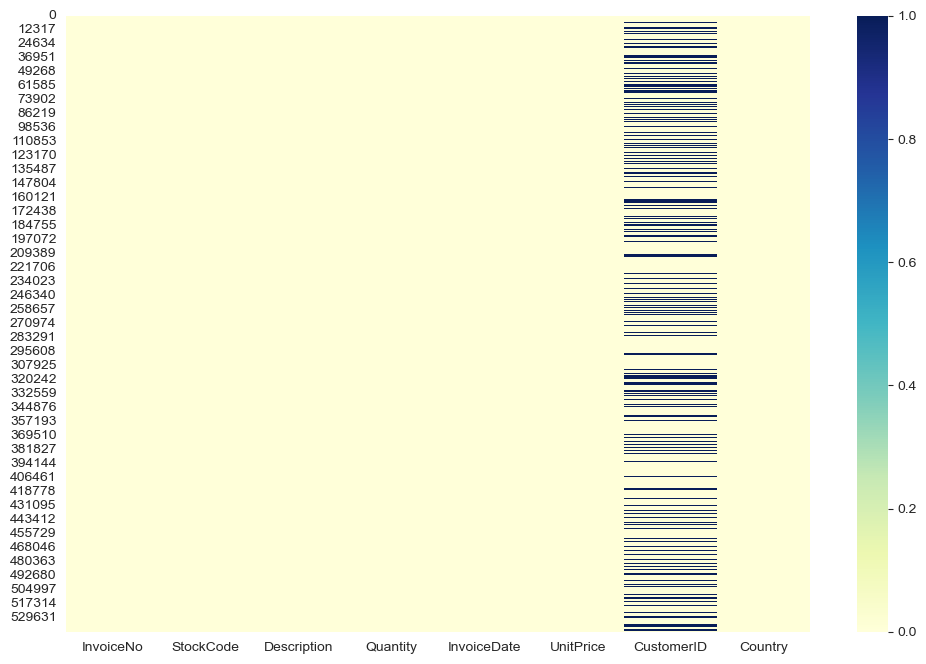

InvoiceNo        0.0%
StockCode        0.0%
Description     0.27%
Quantity         0.0%
InvoiceDate      0.0%
UnitPrice        0.0%
CustomerID     24.93%
Country          0.0%
dtype: object


In [3]:
#绘制热图，用于可视化数据集中的缺失值。
#若为缺失值，则为True，颜色为深蓝色。
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
sns.heatmap(data.isnull(),cmap="YlGnBu")
plt.show()

#统计缺失率
count_missing = data.apply(lambda x:'{}%'.format(round(100*sum(x.isnull())/len(x),2)))
print(count_missing)

In [4]:
#删除存在缺失值的条目
data.dropna(subset=['CustomerID','Description'], inplace=True)
data.drop(columns='InvoiceDate', inplace=True)

#单位产品价格
data = data.loc[(data["Quantity"]>0) & (data["UnitPrice"]>=0)]

#数据去重
data.drop_duplicates(inplace=True)

print('The shape is: ',data.shape)
data.head()

The shape is:  (392731, 7)


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom


In [5]:
from sklearn.preprocessing import LabelEncoder

categorical_columns = ['InvoiceNo','Quantity','UnitPrice','Country','Description']

# 创建标签编码器
label_encoder = LabelEncoder()

# 批量进行标签编码
for column in categorical_columns:
    if column in data.columns:
        # 只对存在的列进行标签编码
        data[column] = label_encoder.fit_transform(data[column])


categorical_columns2 = ['StockCode']

# 批量进行标签编码
for column in categorical_columns2:
    if column in data.columns:
        # 将列转换为字符串类型以确保数据类型一致
        data[column] = data[column].astype(str)
        # 进行标签编码
        data[column] = label_encoder.fit_transform(data[column])


In [6]:
# 创建一个函数来检测和去除离群点
def remove_outliers_iqr_adjusted(df, columns, iqr_multiplier):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # 调整的离群点阈值
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR

        # 去除离群点
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df
#使用四分位数（Q1 和 Q3）计算四分位间距（IQR），并根据 IQR 计算出上下限。超出这个范围的值被认为是离群值。


In [7]:
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
import seaborn as sns
# 选择要检测的特征
# 定义要检测的列
columns_to_check = ['Quantity','UnitPrice']
# 去除离群点
cleaned_data_adjusted = remove_outliers_iqr_adjusted(data.copy(), columns_to_check, iqr_multiplier=4)


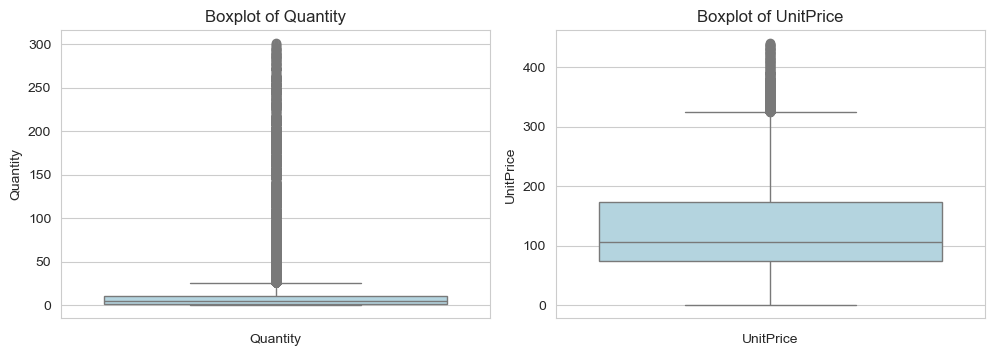

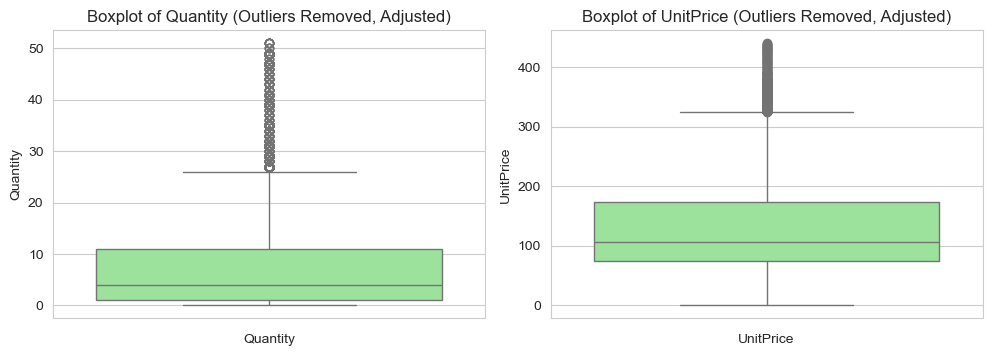

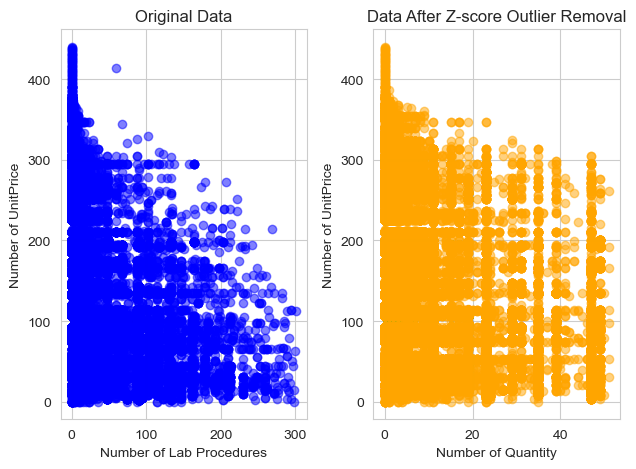

In [8]:
# 可视化原始数据
plt.figure(figsize=(15, 10))
for i, column in enumerate(columns_to_check):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(data=data[column], color='lightblue')
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
plt.tight_layout()
plt.show()

# 可视化去除离群点后的数据
plt.figure(figsize=(15, 10))
for i, column in enumerate(columns_to_check):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(data=cleaned_data_adjusted[column], color='lightgreen')
    plt.title(f'Boxplot of {column} (Outliers Removed, Adjusted)')
    plt.xlabel(column)
plt.tight_layout()
plt.show()

# 原始数据可视化
plt.subplot(1, 2, 1)
plt.scatter(data['Quantity'], data['UnitPrice'], color='blue', alpha=0.5)
plt.title('Original Data')
plt.xlabel('Number of Lab Procedures')
plt.ylabel('Number of UnitPrice')
plt.grid(True)

# 去除离群点后的数据可视化
plt.subplot(1, 2, 2)
plt.scatter(cleaned_data_adjusted['Quantity'], cleaned_data_adjusted['UnitPrice'], color='orange', alpha=0.5)
plt.title('Data After Z-score Outlier Removal')
plt.xlabel('Number of Quantity')
plt.ylabel('Number of UnitPrice')
plt.grid(True)
# 保持坐标轴范围一致
# plt.xlim(0, data['Quantity'].max())
# plt.ylim(0, data['UnitPrice'].max())
plt.tight_layout()
plt.show()


In [9]:
#聚类
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 使用所有特征进行聚类
features_to_cluster = cleaned_data_adjusted.copy()

# 标准化特征
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_to_cluster)


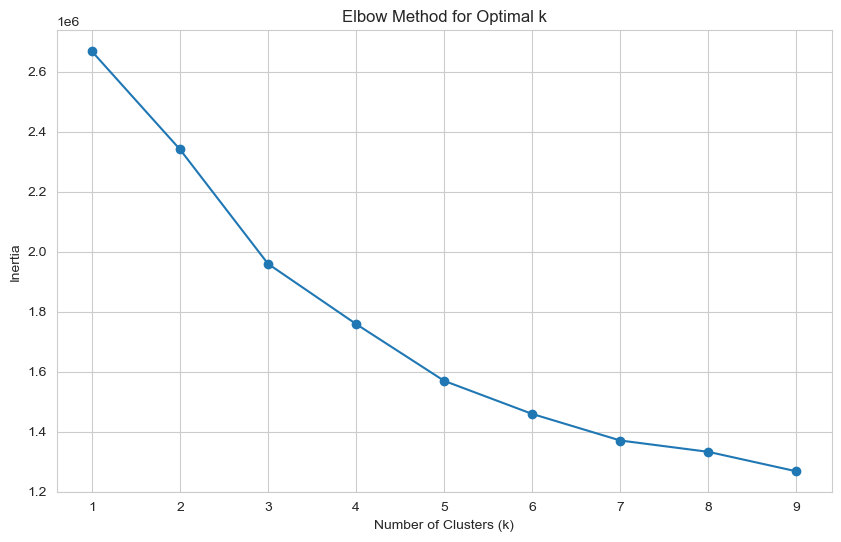

In [10]:
# 确定聚类的数量 (k)
inertia = []
k_range = range(1, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# 绘制肘部法则图
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()


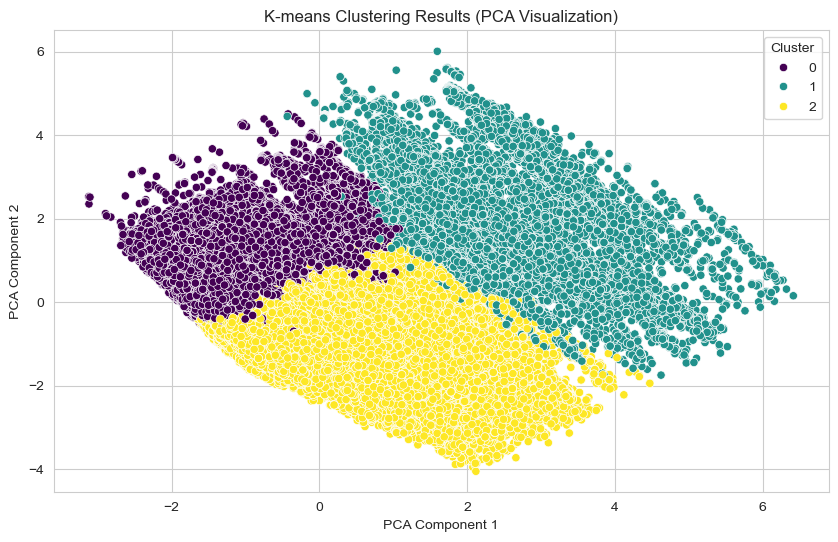

Cluster
2    223048
0    124842
1     33248
Name: count, dtype: int64


In [13]:
k = 3  # 根据肘部法则选择的聚类数
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_features)

# 将聚类结果添加到 cleaned_data_adjusted 中
cleaned_data_adjusted['Cluster'] = cluster_labels

# 可视化聚类结果
plt.figure(figsize=(10, 6))
# 使用前两个主成分进行可视化
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)


sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=cleaned_data_adjusted['Cluster'], palette='viridis')
plt.title('K-means Clustering Results (PCA Visualization)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# 输出每个聚类的样本数
print(cleaned_data_adjusted['Cluster'].value_counts())
